In [1]:
from src import MACGenerator, UDP_TX, SlidingBook
import src.TX as TX

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import socket
import struct
import time
import json
import cv2

import sys

sys.path.append('..')
import utils.utils as utils








def tx_param(IP, PORT, param:dict):
# send the parameters to the receiver and the time.time() to synchronize the sender and the receiver
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((IP, PORT))
        data = json.dumps(param).encode()

        for i in range(len(data)//1000):
            s.send(data[i*1000:(i+1)*1000])
            time.sleep(.01)
        s.send(data[(i+1)*1000:])
        time.sleep(.1)
        s.send(b'END')
        time.sleep(.1)
        data = time.time()
        data = struct.pack('d', data)
        s.send(data)
        res = s.recv(1024)
        if res == b'ABORT':
            print("The receiver has aborted the connection")
    
        s.close()
    return True if res == b'OK' else False



def run_experiment(IP, PORT, param:dict):
    # Capture video from the default camera
    cap = cv2.VideoCapture(0) 
    # Define the compression parameters for Progressive JPEG
    compression_params = [cv2.IMWRITE_JPEG_PROGRESSIVE, 1, cv2.IMWRITE_JPEG_QUALITY, param['QUALITY']]
    ## counting the number of frames per second

    start_time = time.time()
    runTime_cnt = time.time()
    frame_counter = 0
    average_tx_size = 0
    while True:
        ret, frame = cap.read()
        # Encode the image to JPEG format in memory
        success, encoded_frame = cv2.imencode('.jpg', frame, compression_params)
        data = encoded_frame.tobytes()
        average_tx_size+=len(data)//1000

        #############################  TX  ########################################
        buffer = SlidingBook(num_pages=40, page_size=len(param['X']))
        page_processor = MACGenerator(X = param['X'], Y = param['Y'], secret_key=param['KEY'].encode(), digestmod=param['DIGESTMOD'])
        udp_tx = UDP_TX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte = param['PAYLOAD_SIZE_BYTE'])
        pages = udp_tx.segment_to_pages(data)
        udp_tx.transmit(pages, param['ATTACK_PROBABILITY'])
        ###########################################################################

        cv2.imshow('Webcam', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

        # print the frame rate
        frame_counter += 1
        if time.time() - start_time >= 1:
            print("frame per second: ", frame_counter, "fps ,data rate: ", average_tx_size, "KB/s")
            frame_counter = 0
            start_time = time.time()
            average_tx_size = 0
        if time.time() - runTime_cnt >= param['DURATION']:
            break
    cv2.destroyAllWindows()
    cap.release()
    



#### test the function
###### IP, PORRT ######
IP = "10.42.0.15"
PORT = 23422
#######################

#### parameters that needs to be exhanged between the sender and the receiver #####
param ={}

#traditional MAC
X = np.eye(10)
Y = np.eye(10)

param['X'] = X.tolist()
param['Y'] = Y.tolist()
param['KEY'] = "key"
param['DIGESTMOD'] = 'sha384'
param['PAYLOAD_SIZE_BYTE']= 1024
param['QUALITY'] = 70   # param['QUALITY'] of the JPEG compression
param['ATTACK_PROBABILITY'] = 0.00  # probability of the attack
param['DURATION'] = 10  # running time of the sender in seconds
####################################################################################
res = tx_param(IP, PORT, param)
print(res)
if res:
    run_experiment(IP, PORT, param)

The receiver has aborted the connection
False


Total runtime for experiments:  270.0 minutes


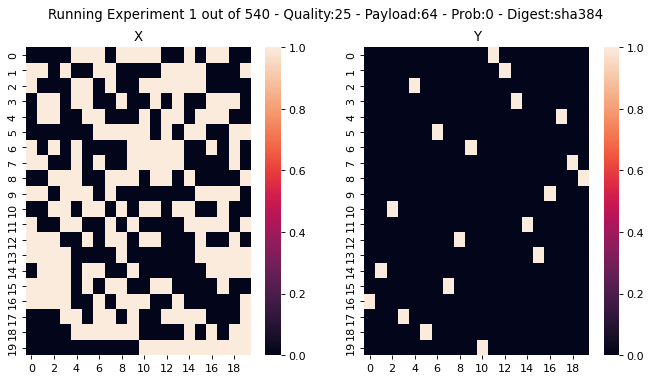

ConnectionRefusedError: [Errno 111] Connection refused

In [2]:
###### IP, PORRT ######
IP = "10.42.0.15"
PORT = 23422
#######################



################# number of experimnets ###############
qualities = [25, 75]
payload_sizes = [64, 128, 1024]
attack_probabilities = [0, 0.05, 0.1, 0.2, 0.3]

# qualities = [60]
# payload_sizes = [32, 128]
# attack_probabilities = [0, 0.001]

digets = ['sha384', 'sha512']
Duration = 30 # Seconds
exp = utils.Load_Experiments("../Examples/Xs.pkl")
#######################################################

total_number_of_experiments = 0
for i in range(len(exp)):
    if not(exp[i]['parameters']['m_nr'] == 20 and exp[i]['parameters']['t_nr'] == 20) :
        continue
    if np.array_equal(np.array(exp[i]['results']['X']),np.ones(np.array(exp[i]['results']['X']).shape)) or exp[i]['parameters']['q'] != 1:
        continue
    total_number_of_experiments += 1

total_number_of_experiments = len(qualities)*len(payload_sizes)*len(attack_probabilities)*len(digets)*total_number_of_experiments
print("Total runtime for experiments: ", total_number_of_experiments*Duration/60, "minutes")

cnt = 0
for i in range(len(exp)):
    if not(exp[i]['parameters']['m_nr'] == 20 and exp[i]['parameters']['t_nr'] == 20):
        continue
    if np.array_equal(np.array(exp[i]['results']['X']),np.ones(np.array(exp[i]['results']['X']).shape)) or exp[i]['parameters']['q'] != 1:
        continue

    X = exp[i]['results']['X']
    Y = utils.Get_Y(X)
    # try:
    #     if Y := utils.Get_Y(X) is None:
    #         continue
    # except:
    #     continue

    for quality in qualities:
        for payload_size in payload_sizes:
            for attack_prob in attack_probabilities:
                for digest in digets:

                    param = {}
                    param['X'] = X.tolist()
                    param['Y'] = Y.tolist()
                    param['KEY'] = "key"
                    param['DIGESTMOD'] = digest
                    param['PAYLOAD_SIZE_BYTE'] = payload_size
                    param['QUALITY'] = quality
                    param['ATTACK_PROBABILITY'] = attack_prob
                    param['DURATION'] = Duration

                    plt.figure(figsize = (10,5), dpi=80)
                    plt.subplot(1, 2, 1)
                    sns.heatmap(param['X'])
                    plt.title('X')
                    plt.subplot(1, 2, 2)
                    try:
                        sns.heatmap(param['Y'])
                        plt.title('Y')
                    except:
                        pass
                    cnt += 1
                    plt.suptitle(f'Running Experiment {cnt} out of {total_number_of_experiments}' + ' - Quality:' + str(quality) + ' - Payload:' + str(payload_size) + ' - Prob:' + str(attack_prob) + ' - Digest:' + digest)
                    plt.show()

                    res = tx_param(IP, PORT, param)
                    if res:
                        run_experiment(IP, PORT, param)
                        time.sleep(1)


                    

           


